In [50]:
#Importo las librerías necesarias

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyarrow.parquet as pq
import seaborn as sns
import pandas as pd
import re

Comienzo a realizar el EDA con el archivo de Steam_Games

In [61]:
df_steam_games = pq.read_table(r'..\Colab\steam_games_compr.parquet').to_pandas()

# Elimino las filas con valores nulos en todas sus entradas
df_steam_games = df_steam_games.dropna(how='all')

In [62]:
# Convierto las listas de la columnas en una cadena separada por comas
df_steam_games['genres'] = df_steam_games['genres'].apply(lambda x: str(x).replace("[", "").replace("]", ""))
df_steam_games['tags'] = df_steam_games['tags'].apply(lambda x: str(x).replace("[", "").replace("]", ""))
df_steam_games['specs'] = df_steam_games['specs'].apply(lambda x: str(x).replace("[", "").replace("]", ""))

In [63]:
df_steam_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88310,Kotoshiro,"'Action', 'Casual', 'Indie', 'Simulation', 'St...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"'Strategy', 'Action', 'Indie', 'Casual', 'Simu...",http://steamcommunity.com/app/761140/reviews/?...,'Single-player',4.99,False,761140.0,Kotoshiro
88311,"Making Fun, Inc.","'Free to Play', 'Indie', 'RPG', 'Strategy'",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"'Free to Play', 'Strategy', 'Indie', 'RPG', 'C...",http://steamcommunity.com/app/643980/reviews/?...,"'Single-player', 'Multi-player', 'Online Multi...",Free To Play,False,643980.0,Secret Level SRL
88312,Poolians.com,"'Casual', 'Free to Play', 'Indie', 'Simulation...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"'Free to Play', 'Simulation', 'Sports', 'Casua...",http://steamcommunity.com/app/670290/reviews/?...,"'Single-player', 'Multi-player', 'Online Multi...",Free to Play,False,670290.0,Poolians.com
88313,彼岸领域,"'Action', 'Adventure', 'Casual'",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"'Action', 'Adventure', 'Casual'",http://steamcommunity.com/app/767400/reviews/?...,'Single-player',0.99,False,767400.0,彼岸领域
88314,None,None,Log Challenge,None,http://store.steampowered.com/app/773570/Log_C...,None,"'Action', 'Indie', 'Casual', 'Sports'",http://steamcommunity.com/app/773570/reviews/?...,"'Single-player', 'Full controller support', 'H...",2.99,False,773570.0,None


In [64]:
# Separa la cadena por comas y agrego una fila por cada valor individual
df_steam_games['genres'] = df_steam_games['genres'].str.split(', ')
df_steam_games = df_steam_games.explode('genres')
df_steam_games['genres'] = df_steam_games['genres'].apply(lambda x: str(x).replace("'", ""))

In [65]:
# Separa la cadena por comas y agrego una fila por cada valor individual
df_steam_games['tags'] = df_steam_games['tags'].str.split(', ')
df_steam_games = df_steam_games.explode('tags')
df_steam_games['tags'] = df_steam_games['tags'].apply(lambda x: str(x).replace("'", ""))

In [66]:
# Elimino las filas en donde la columna price es nulo
df_steam_games.dropna(subset=['price'], inplace=True)

# Elimino las filas en donde la columna id es nulo
df_steam_games.dropna(subset=['id'], inplace=True)


In [67]:
# Selecciono el año de la columna release_date y la elimino
df_steam_games['anio'] = df_steam_games['release_date'].str.extract(r'(\d{4})')
df_steam_games.drop('release_date', axis=1, inplace=True)

In [68]:
# Verifico los outliers de año
df_steam_games[df_steam_games['anio'] > '2030'].shape[0]

0

In [69]:
df_steam_games.reset_index(drop=True, inplace=True)

In [71]:
# Lleno los nulos de 'developer' con el valor correspondiente de 'publisher'.

publisher = pd.Series(df_steam_games['publisher'])
developer = pd.Series(df_steam_games['developer'])

for i in range(len(publisher)):
  if developer[i] is None:
    developer[i] = publisher[i]
  else:
    continue

df_steam_games['developer'] = developer

In [70]:
# Elimino las columnas innecesarias
columnas = ['title','url','reviews_url','early_access']
df_steam_games.drop(columns=columnas, axis=1, inplace=True)

In [73]:
# Elimino las filas donde 'anio' es nulo
df_steam_games.dropna(subset=['anio'], inplace=True)

# Convierto 'anio' a tipo integer
df_steam_games['anio'] = df_steam_games['anio'].astype(int)

# Convierto 'id' a tipo integer
df_steam_games['id'] = df_steam_games['id'].astype(int)

In [72]:
# Elimino la columna 'publisher'
df_steam_games.drop(columns = ['publisher'],axis=1,inplace=True)

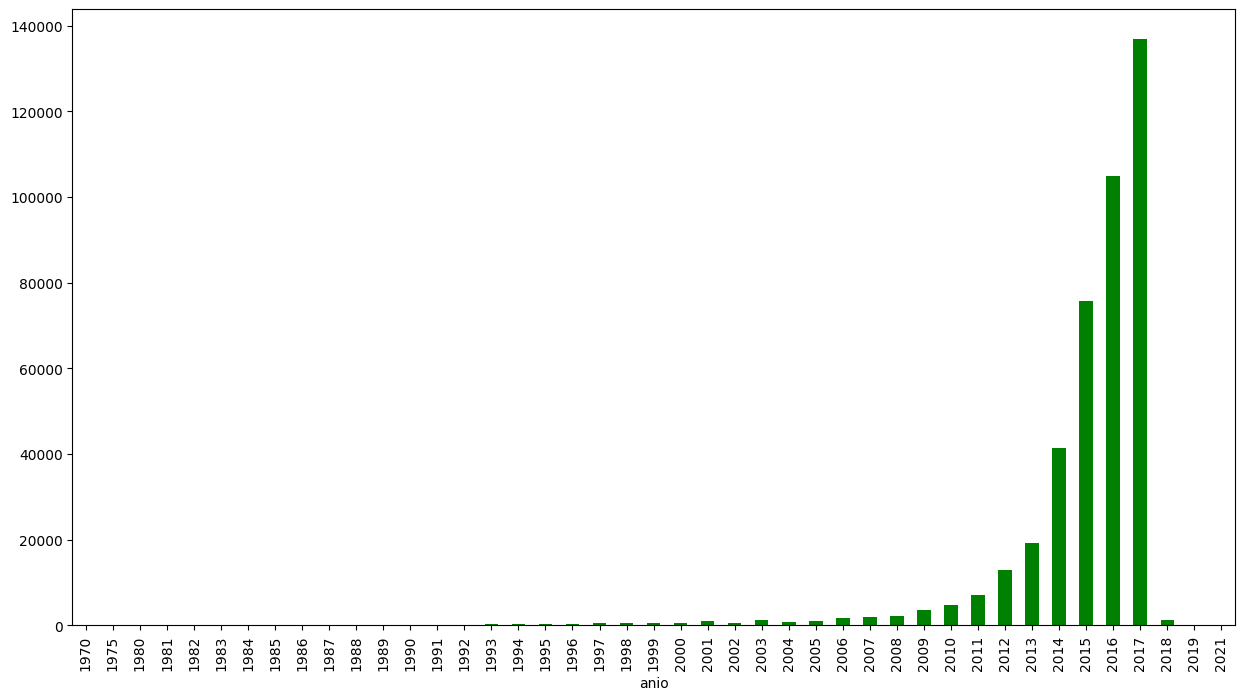

In [74]:
# Verifico la distribución de los años
df_steam_games['anio'].value_counts().sort_index().plot(kind='bar', figsize=(15, 8), color='green')
plt.show()

In [75]:
# Tratamiento de la columna 'price'

# Asigno valor 0.0 a las filas de 'price' que contienen la palabra 'free'
df_steam_games.loc[df_steam_games['price'].str.contains(r'\bfree\b', case=False, regex=True), 'price'] = '0.0'

# Extraigo el precio de las filas que contienen mezcla de letras y números
# Elimino las filas que no contengan información numérica
df_steam_games['price'] = df_steam_games['price'].str.extract(r'(\d+.\d+)')

# Elimino las filas de 'price' que contienen valores nulos
df_steam_games.dropna(subset=['price'], inplace=True)

# Convierto la columna a tipo float
df_steam_games['price'] = df_steam_games['price'].astype(float)

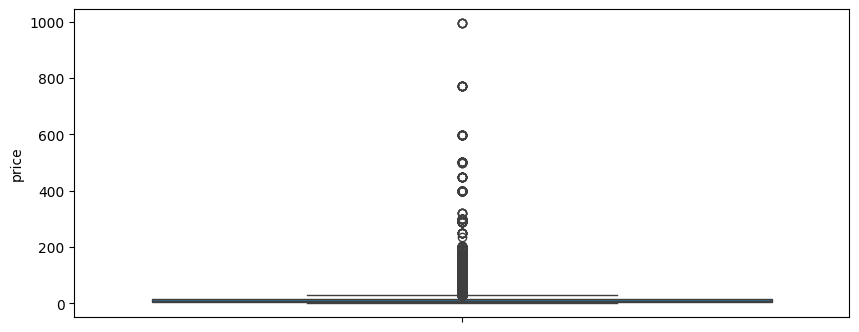

In [76]:
# Realizo un boxplot para ver la distribución de 'price'


fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(y=df_steam_games['price'], ax=ax)
plt.show()

In [77]:
q1 = df_steam_games['price'].quantile(0.25)
q3 = df_steam_games['price'].quantile(0.75)
iqr = q3 - q1

In [79]:
# Precios que estén por fuera del siguiente intervalo son considerados outliers
(q1 - 1.5 * iqr), (q3 + 1.5 * iqr)

# Consultando los precios de los videojuegos online de la plataforma Steam descubro que más de 
# 250 es un precio muy elevado por lo que infiero que los precios por encima de ese valor son 
# outliers y procedo a reemplazarlos con la mediana.


(-12.01, 27.990000000000002)

In [80]:
# Identifico precios que sean mayores a 250.0 y los reemplazo con la mediana
df_steam_games.loc[df_steam_games['price'] > 250.0, 'price'] = df_steam_games['price'].median()

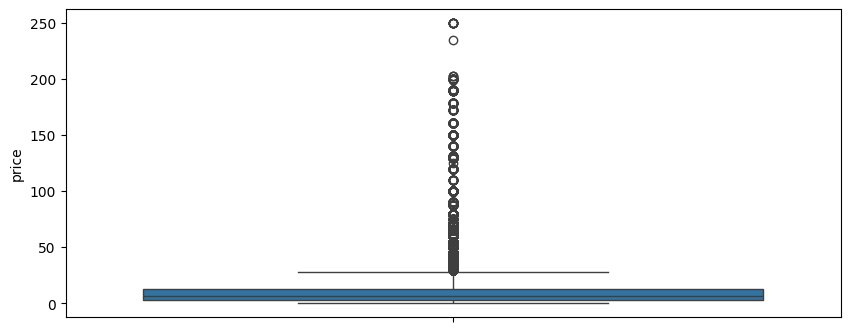

In [81]:
# Realizo un boxplot para ver la distribución de 'price' sin outliers
# Teniendo en cuenta que pueden haber juegos que valgan hasta $200

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(y=df_steam_games['price'], ax=ax)
plt.show()

In [82]:
def limpiar_y_convertir_a_minusculas(df):
    # Lista de caracteres especiales a reemplazar
    caracteres_especiales = ['-', '!', '¡', '?', '¿', '"', "'", ',', '&', "''", '_', '[', ']', ';', '(', ')','  ']

    for caracter in caracteres_especiales:
        df = df.apply(lambda x: x.str.replace(caracter, '') if x.dtype == "object" else x)

    df = df.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

    return df

In [83]:
df_steam_games = limpiar_y_convertir_a_minusculas(df_steam_games)
df_steam_games.head(3)

,genres,app_name,tags,specs,price,id,developer,anio
0,action,lost summoner kitty,strategy,singleplayer,4.99,761140,kotoshiro,2018
1,action,lost summoner kitty,action,singleplayer,4.99,761140,kotoshiro,2018
2,action,lost summoner kitty,indie,singleplayer,4.99,761140,kotoshiro,2018


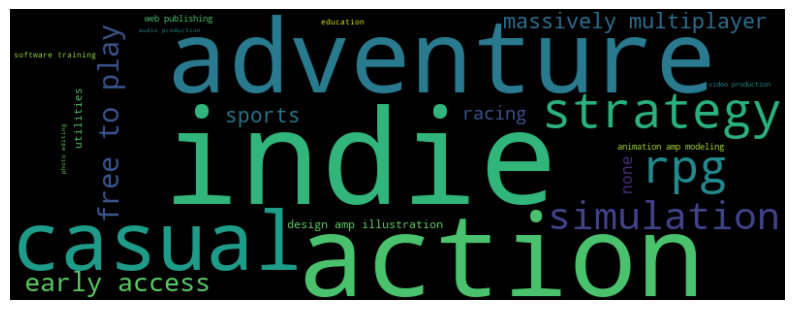

In [84]:
# Cuento la frecuencia de cada género
frecuencia_genero = df_steam_games['genres'].value_counts()

# Creo la nube de palabras
wordcloud = WordCloud(width=800, height=300, background_color='black').generate_from_frequencies(frecuencia_genero)

# Muestro la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

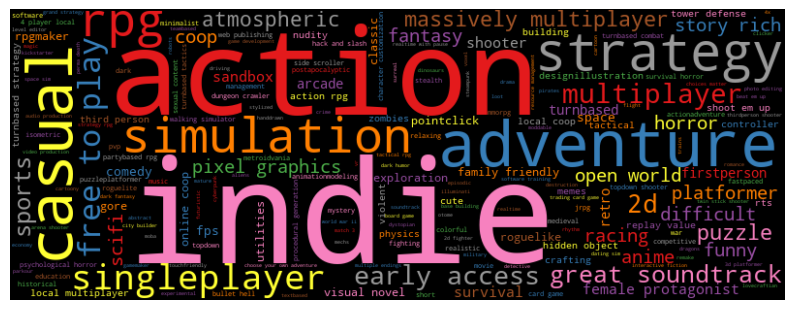

In [94]:

# Cuento la frecuencia de cada tag
frecuencia_genero = df_steam_games['tags'].value_counts()

# Creo la nube de palabras
wordcloud = WordCloud(width=800, height=300, background_color='black', colormap='Set1').generate_from_frequencies(frecuencia_genero)

# Muestra la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

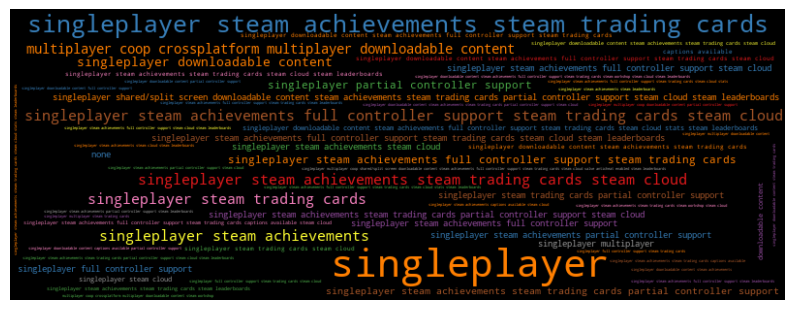

In [97]:
# Cuento la frecuencia de cada spec
frecuencia_genero = df_steam_games['specs'].value_counts()

# Creo la nube de palabras
wordcloud = WordCloud(width=800, height=300, background_color='black', colormap='Set1').generate_from_frequencies(frecuencia_genero)

# Muestro la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [99]:
# Elimino los caracteres especiales de la columna 'app_name'

df_steam_games['app_name'] = df_steam_games['app_name'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_steam_games['app_name'] = df_steam_games['app_name'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [98]:
# Elimino los puntos de la columna 'developer'
df_steam_games['developer'] = df_steam_games['developer'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)

In [100]:
# Elimino palabras irrelevantes en la columna 'developer'
words_to_remove = [
    ' gamesaspyr macvirtual programming linux',
    ' softwareaspyr mac amp linux',
    ' interactive mac/linux',
    'incferal interactive macferal interactive linux ',
    ' incferal interactive macferal interactive linux',
    ' mac amp linux',
    ' interactive mac',
    ' interactive macferal interactive linux'

]

def clean_developer_name(name):
    for word in words_to_remove:
        name = name.replace(word, '').strip()
    return name

In [101]:
df_steam_games['cleaned_developer_column'] = df_steam_games['developer'].apply(clean_developer_name)

In [102]:
df_steam_games['developer'] = df_steam_games['cleaned_developer_column']
df_steam_games.drop('cleaned_developer_column',axis=1, inplace=True)

In [103]:
df_steam_games.head(3)

,genres,app_name,tags,specs,price,id,developer,anio
0,action,lost summoner kitty,strategy,singleplayer,4.99,761140,kotoshiro,2018
1,action,lost summoner kitty,action,singleplayer,4.99,761140,kotoshiro,2018
2,action,lost summoner kitty,indie,singleplayer,4.99,761140,kotoshiro,2018


In [ ]:
# Guardo el dataset procesado para su posterior uso
df_steam_games.to_parquet('df_steam_games_limpio_final.parquet')

In [ ]:
EDA archivo User_items

In [124]:
df_items = pq.read_table(r'../Colab/dfitemsOpen_compr.parquet').to_pandas()
df_items = df_items.dropna(how='all')
df_items = df_items.drop(['0'], axis=1)

In [125]:
df_items.head(3)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10.0,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20.0,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30.0,Day of Defeat,7.0,0.0


In [126]:
# Elimino columnas no relevantes
columnas = ['steam_id', 'user_url']
df_items = df_items.drop(columnas, axis=1)

In [127]:
# Elimino las filas donde 'item_id', 'user_id', 'playtime_forever' son vacios
df_items = df_items.dropna(subset=['item_id', 'user_id', 'playtime_forever'])

# Elimino duplicados
df_items = df_items.drop_duplicates()

In [128]:
# Elimino los caracteres especiales de la columna 'item_name'

df_items['item_name'] = df_items['item_name'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
df_items['item_name'] = df_items['item_name'].apply(lambda x: re.sub(r'\s+', ' ', x))
# Convierto en minúsculas
df_items['item_name'] = df_items['item_name'].str.lower()

In [129]:
# Convierto 'item_id' a integer
df_items['item_id'] = df_items['item_id'].astype(int)

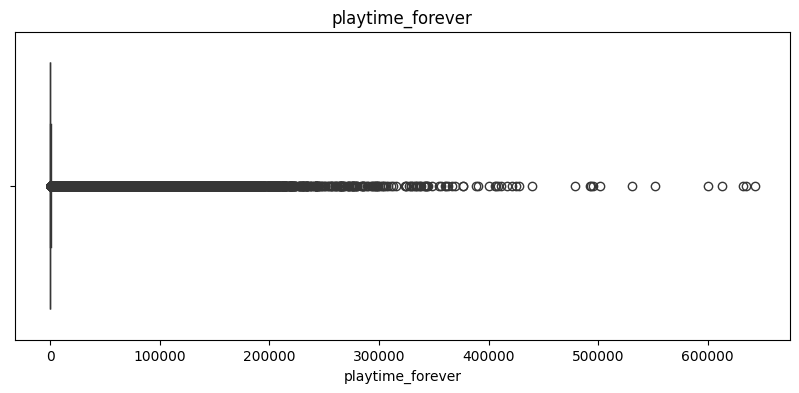

In [130]:

# Realizo un boxplot de 'playtime_forever'
nuevo_esquema_color = "colorblind"
sns.set_palette(nuevo_esquema_color)
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=df_items['playtime_forever'], ax=ax)
plt.title('playtime_forever')
plt.show()



In [131]:
# Detecto outliers de la columna 'playtime_forever'
q1 = df_items['playtime_forever'].quantile(0.25)
q3 = df_items['playtime_forever'].quantile(0.75)
iqr = q3 - q1

In [132]:
# Detectamos outliers de la columna 'playtime_forever'
q1 = df_items['playtime_forever'].quantile(0.25)
q3 = df_items['playtime_forever'].quantile(0.75)
iqr = q3 - q1

In [133]:
# Intervalo donde están los datos que no son atípicos
q3 - 1.5 * iqr,q3 + 1.5 * iqr

(-178.5, 892.5)

In [134]:
# Calculo la mediana y la media
df_items['playtime_forever'].median(), df_items['playtime_forever'].mean()

(34.0, 994.8077144605081)

In [135]:
# Imputo los outliers con la mediana, ya que esta no es sensible a outliers
df_items.loc[df_items['playtime_forever'] > (q3 + 1.5 * iqr), 'playtime_forever'] = df_items['playtime_forever'].median()

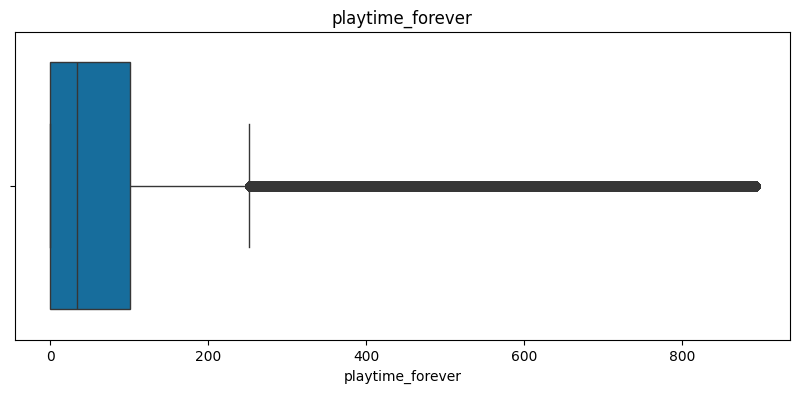

In [136]:

# Realizo un boxplot de 'playtime_forever' para ver cómo quedaron los valores
nuevo_esquema_color = "colorblind"
sns.set_palette(nuevo_esquema_color)
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=df_items['playtime_forever'], ax=ax)
plt.title('playtime_forever')
plt.show()

In [ ]:
# Guardo el dataset procesado para su posterior uso
df_items.to_parquet(r'../Colab/df_items_limpio_compr.parquet')

EDA user_reviews

In [141]:
#Importo librerias faltantes
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
import nltk


In [192]:
# Leo el archivo, elimino las filas que son nulas en todas sus entradas
df_reviews = pq.read_table(r'../Colab/dfreviewsOpen_compr.parquet').to_pandas()
df_reviews.drop(['0'], axis=1, inplace=True)
df_reviews = df_reviews.dropna(how='all')

In [193]:
# Elimino las filas donde la columna 'item_id' es nulo
df_reviews.dropna(subset=['item_id'], inplace=True)

In [194]:
# Elimino columnas irrelevantes
columnas = ['user_url','funny','helpful']
df_reviews.drop(columns=columnas, inplace=True)

In [195]:
# Reemplazo el año de 'posted' por el año en que se hizo la ultima 
# modificacion del review

# Extraigo el año de 'posted' y 'last_edited' con expresiones regulares
df_reviews['posted_year'] = df_reviews['posted'].str.extract(r'(\d{4})')
df_reviews['last_edited_year'] = df_reviews['last_edited'].str.extract(r'(\d{4})')

# Elimino las columnas originales 'posted' y 'last_edited' si lo deseas
df_reviews.drop(columns=['posted', 'last_edited','last_edited_year'], inplace=True)

# Cambio el nombre de 'posted_year' por 'posted'
df_reviews.rename(columns={'posted_year': 'posted'}, inplace=True)

# Elimino las filas donde 'posted' es nulo
df_reviews.dropna(subset=['posted'], inplace=True)

In [197]:
def limpiar_y_convertir_a_minusculas(df):
    # Lista de caracteres especiales a reemplazar
    caracteres_especiales = ['-', '!', '¡', '?', '¿', '"', "'", ',', '&', "''", '_', '[', ']', ';', '(', ')','  ']

    for caracter in caracteres_especiales:
        df = df.apply(lambda x: x.str.replace(caracter, '') if x.dtype == "object" else x)

    df = df.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

    return df

In [198]:
# Guardo la columna 'user_id'
user_id = df_reviews['user_id']

In [199]:
# Convierto todas las columnas a object
df_reviews = df_reviews.apply(lambda x: x.astype(str) if x.dtype == "object" else x)

In [200]:
df_reviews = limpiar_y_convertir_a_minusculas(df_reviews)

In [201]:
# Convierto 'item_id' a integer
df_reviews['item_id'] = df_reviews['item_id'].astype(int)


In [203]:
# Convierto 'posted' a integer
df_reviews['posted'] = df_reviews['posted'].astype(int)


In [207]:
df_reviews.tail(5)

,user_id,item_id,recommend,review,posted
59280,wayfeng,730,true,its funnnnnnnn,2015
59283,76561198251004808,253980,true,awesome fantasy game if you dont mind the grap...,2015
59293,72947282842,730,true,prettyy mad game,2015
59295,ApxLGhost,730,true,amazing game 10/10,2015
59304,76561198267374962,369200,true,why i voted yes 1. girl characters have boobs....,2015


In [208]:
# Hago el analisis de sentimiento de la columna review
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...


True

In [209]:
# Función para limpiar el texto de la columna 'review'
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales y puntuación
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])  # Eliminar palabras de parada
    text = ' '.join([Word(word).lemmatize() for word in text.split()])  # Lematización
    
    return text

In [210]:
# Aplico limpieza a la columna 'user_reviews'
df_reviews['clean_reviews'] = df_reviews['review'].apply(clean_text)

In [211]:
# Función para el análisis de sentimiento
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity < 0:
        return 0  # Malo
    elif analysis.sentiment.polarity == 0:
        return 1  # Neutral
    else:
        return 2  # Positivo

In [212]:
# Aplico el análisis de sentimiento a la columna 'clean_reviews' y creo una nueva columna 'sentiment_analysis'
df_reviews['sentiment_analysis'] = df_reviews['clean_reviews'].apply(get_sentiment)

In [214]:
# Elimino la columna reviews
df_reviews.drop(columns='review', inplace=True)

In [215]:
df_reviews.head(2)

,user_id,item_id,recommend,posted,clean_reviews,sentiment_analysis
0,76561197970982479,1250,true,2011,simple yet great replayability opinion zombie ...,2
1,76561197970982479,22200,true,2011,unique worth playthrough,2


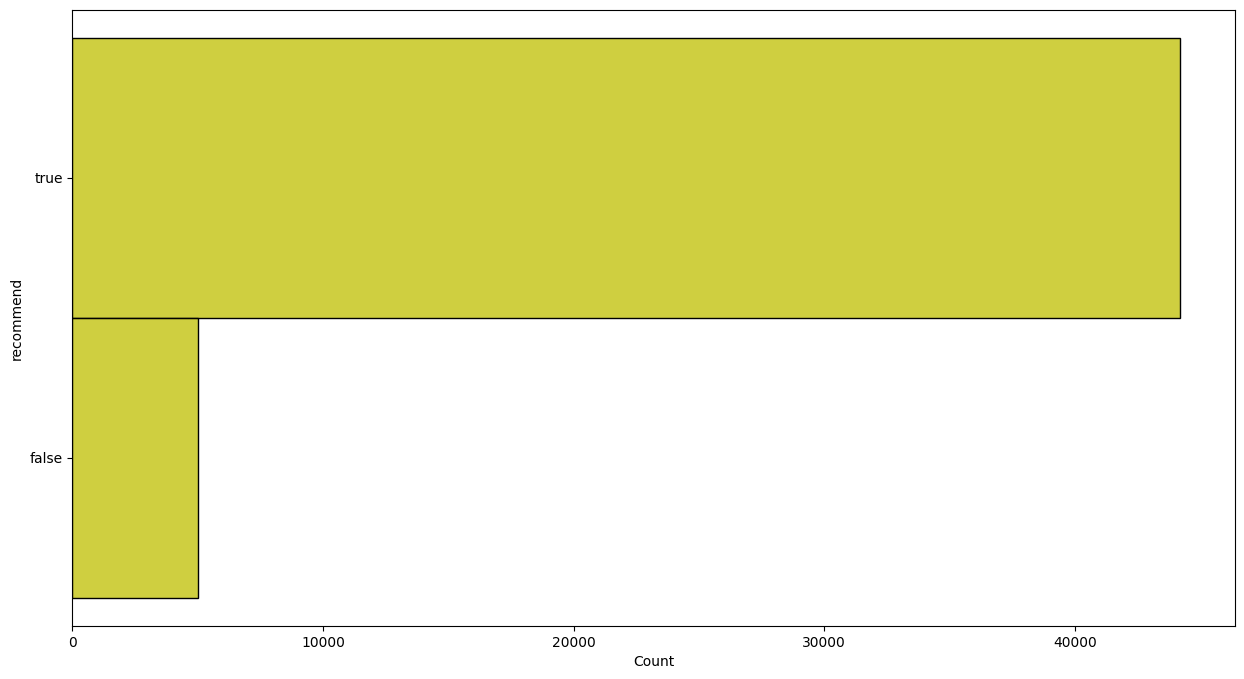

In [218]:
# Realizo un barplot de recommend, para detectar outliers

plt.figure(figsize=(15, 8))
sns.histplot(data=df_reviews, y='recommend', bins=30, color='y')
plt.show()

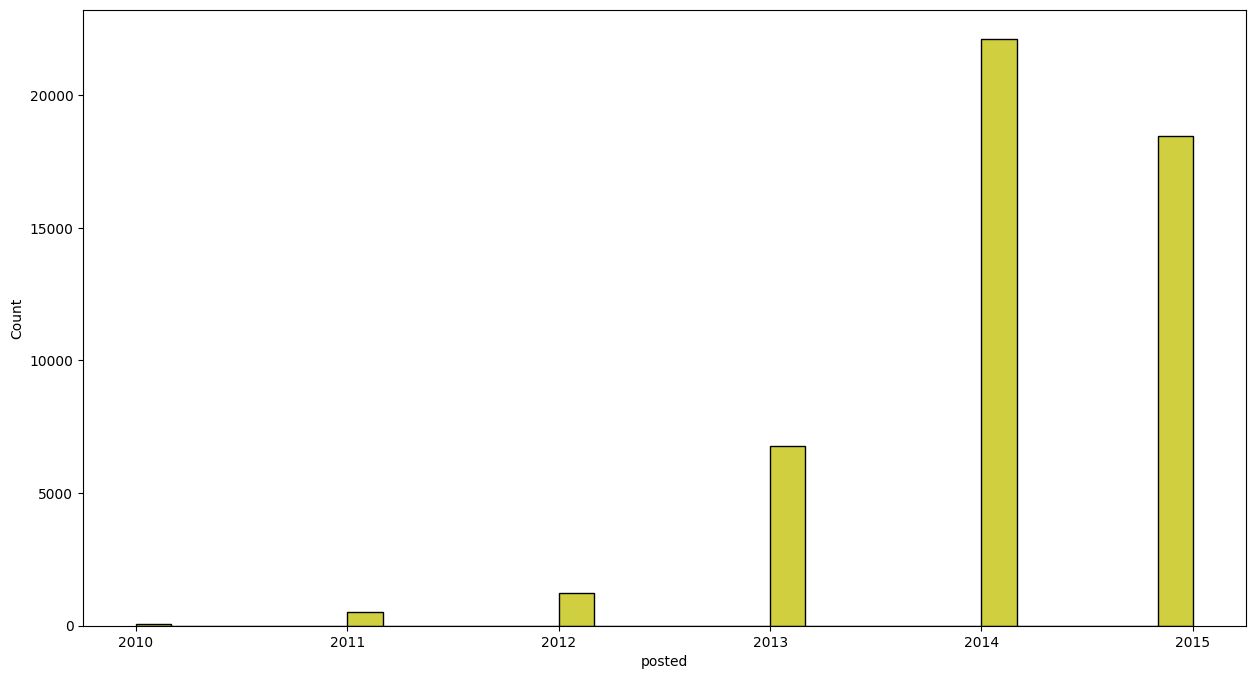

In [220]:
# Realizo un barplot de posted, para detectar outliers

plt.figure(figsize=(15, 8))
sns.histplot(data=df_reviews, x='posted', bins=30, color='y')
plt.show()